# Load data

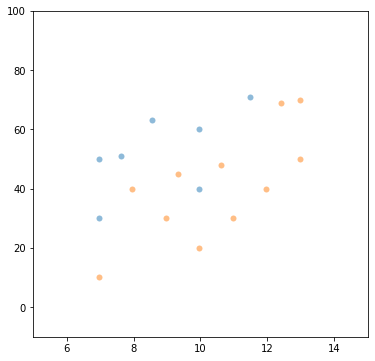

In [66]:
import numpy as np
X = np.array([[ 9.96578428, 60.],[ 9.96578428, 40.],[ 9.96578428, 20.],
       [10.96578428, 30.],[11.96578428, 40.],[12.96578428, 50.],
       [12.96578428, 70.],[8.96578428, 30. ],[ 7.96578428, 40.],
       [ 6.96578428, 50.],[ 6.96578428, 30.],[ 6.96578428, 10.],
       [11.4655664 , 71.],[ 8.56605404, 63.],[12.41574177, 69.],
       [10.61562964, 48.],[ 7.61470984, 51.],[ 9.31514956, 45.]])
Y = np.array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.]]).T

# plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
def plot(X,Y):
    
    mask = Y[:, 0] == 1

    plt.figure(figsize=(6, 6))
    plt.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)

    plt.ylim(-10, 100)
    plt.xlim(5, 15)

    _ = plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)

plot(X,Y)

In [67]:
# Evaluate real function and the predicted probability
res = 500
xx, yy = np.meshgrid(np.linspace(5, 15, res),
                     np.linspace(- 10, 120, res))
Xplot =  np.vstack((xx.flatten(), yy.flatten())).T


# Building models by GPFlow and GPy

In [78]:
# Code followed the Notebook : https://gpflow.readthedocs.io/en/develop/notebooks/basics/classification.html

import tensorflow as tf
import tensorflow_probability as tfp
import gpflow
from gpflow.utilities import print_summary, set_trainable, to_default_float
gpflow.config.set_default_summary_fmt("notebook")

def testGPFlow(k):
    m = gpflow.models.VGP(
        (X, Y), 
        kernel= k,
        likelihood=gpflow.likelihoods.Bernoulli()
    )
    print("\n ########### Model before optimzation ########### \n")
    print_summary(m)
    
    print("\n ########### Model after optimzation ########### \n")
    opt = gpflow.optimizers.Scipy()
    res = opt.minimize(
        m.training_loss, variables=m.trainable_variables, options=dict(maxiter=2500), method="L-BFGS-B"
    )        

    print(' Message: ' + str(res.message) + '\n Status = ' + str(res.status) + '\n Number of iterations = ' + str(res.nit))
    print_summary(m)
    
    means, _ = m.predict_y(Xplot)  # here we only care about the mean
    y_prob = means.numpy().reshape(*xx.shape)

    print("Fitting model using GPFlow")
    plot(X,Y)

    _ = plt.contour(
        xx,
        yy,
        y_prob,
        [0.5],  # plot the p=0.5 contour line only
        colors="k",
        linewidths=1.8,
        zorder=100,
    )

In [79]:
import GPy 

def testGPy(k):
    m = GPy.models.GPClassification(X,Y,k)
    print("\n ########### Model before optimzation ########### \n",m)
    for i in range(5):
        m.optimize('bfgs', max_iters=50) #first runs EP and then optimizes the kernel parameters
    print("\n ########### Model after optimzation ########### \n",m)
    
    p = m.predict(Xplot)[0].reshape((res, res)) 
    
    print("Fitting model using GPy")
    plot(X,Y)

    _ = plt.contour(
        xx,
        yy,
        p,
        [0.5],  # plot the p=0.5 contour line only
        colors="k",
        linewidths=1.8,
        zorder=100,
    )

## Tests with Squared Exponential kernel - GPFlow and GPy passed


 ########### Model before optimzation ########### 



name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,7.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.2
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[1., 0., 0...."



 ########### Model after optimzation ########### 

 Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
 Status = 0
 Number of iterations = 59


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.020009250364416063
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.20008418482807294
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[0.11151006...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[9.93762165e-001, 0.00000000e+000, 0.00000000e+000..."


Fitting model using GPFlow


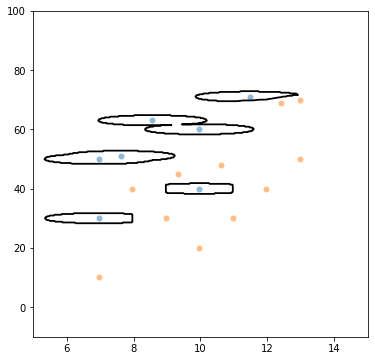

In [80]:
k = gpflow.kernels.SquaredExponential(variance=7.0, lengthscales=0.2)
testGPFlow(k)


 ########### Model before optimzation ########### 
 
Name : gp_classification
Objective : 12.476649192044151
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    7.0  |      +ve      |        
  rbf.lengthscale     |    0.2  |      +ve      |        

 ########### Model after optimzation ########### 
 
Name : gp_classification
Objective : 12.476649192044153
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    7.0  |      +ve      |        
  rbf.lengthscale     |    0.2  |      +ve      |        
Fitting model using GPy


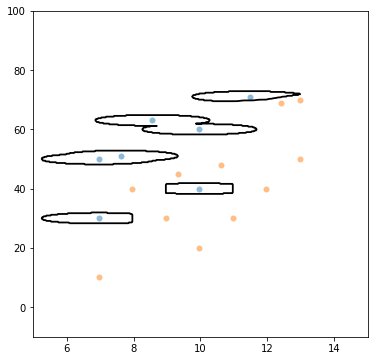

In [81]:
k = GPy.kern.RBF(input_dim = 2, variance=7., lengthscale=0.2)
testGPy(k)

## Tests with Linear kernel - GPy passed, GPFlow failed


 ########### Model before optimzation ########### 
 
Name : gp_classification
Objective : 14.101384368431932
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  linear.variances    |    1.0  |      +ve      |        

 ########### Model after optimzation ########### 
 
Name : gp_classification
Objective : 12.713229845296183
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  gp_classification.  |                value  |  constraints  |  priors
  linear.variances    |  0.06804522984792429  |      +ve      |        
Fitting model using GPy


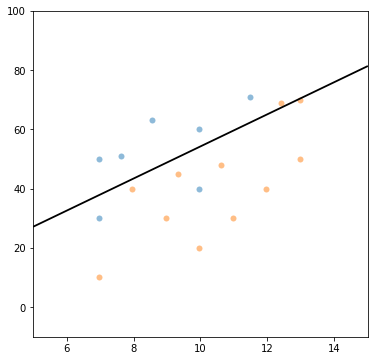

In [89]:
k = GPy.kern.Linear(input_dim = 2, variances=1)
testGPy(k)


 ########### Model before optimzation ########### 



name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[1., 0., 0...."



 ########### Model after optimzation ########### 

 Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
 Status = 0
 Number of iterations = 66


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.6771375618593418
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[-7.48381824e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[7.24435383e-01, 0.00000000e+00, 0.00000000e+00..."


Fitting model using GPFlow


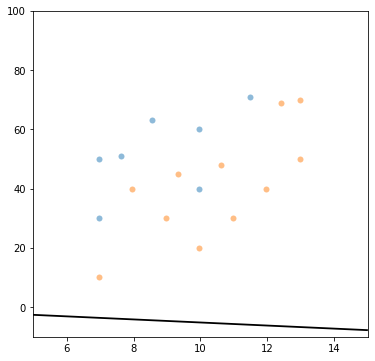

In [87]:
k = gpflow.kernels.Linear(variance= 1)
#k = gpflow.kernels.Linear(active_dims=[1],variance= 1)

testGPFlow(k)

## Tests with  Squared Exponential + Linear kernel - GPy passed, GPFlow failed


 ########### Model before optimzation ########### 
 
Name : gp_classification
Objective : 12.181883073219396
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp_classification.    |  value  |  constraints  |  priors
  sum.rbf.variance      |    7.0  |      +ve      |        
  sum.rbf.lengthscale   |    0.2  |      +ve      |        
  sum.linear.variances  |    1.0  |      +ve      |        

 ########### Model after optimzation ########### 
 
Name : gp_classification
Objective : 12.06781370483843
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp_classification.    |                value  |  constraints  |  priors
  sum.rbf.variance      |    8.099254099609567  |      +ve      |        
  sum.rbf.lengthscale   |  0.06969803704129734  |      +ve      |        
  sum.linear.variances  |   0.6117783505543721  |      +ve      |        
Fitting model using GPy


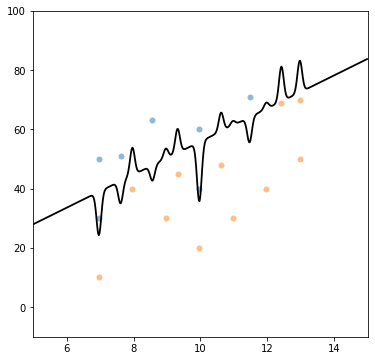

In [93]:
k = GPy.kern.RBF(input_dim = 1, variance=7., lengthscale=0.2) + GPy.kern.Linear(input_dim = 2, variances=1)
testGPy(k)


 ########### Model before optimzation ########### 



name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,7.0
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.2
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[1., 0., 0...."



 ########### Model after optimzation ########### 

 Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
 Status = 0
 Number of iterations = 221


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.06905094911694555
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.7322338319765236
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.2320812692835325e-12
VGP.q_mu,Parameter,,,True,"(18, 1)",float64,[[-0.43183408...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 18, 18)",float64,"[[[8.19114716e-01, 0.00000000e+00, 0.00000000e+00..."


Fitting model using GPFlow


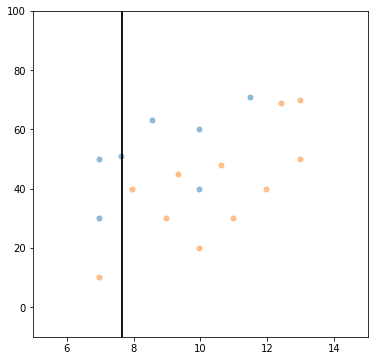

In [92]:
k= gpflow.kernels.SquaredExponential(active_dims=[0],variance=7.0, lengthscales=0.2) + \
    gpflow.kernels.Linear(variance= 1)

testGPFlow(k)